### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

/home/paul/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# For now set a small population for Leeds (down by a factor of 20):

#### TODO: delete this box

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population'] // 20

In [5]:
# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

# We assume that Covid survivors, and the vaccinated, have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is square for the indian variant (and 80% squared is 64%)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                            PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.33)

soc = UKSociety(config=SOCIETY_CFG)

2021-05-24 16:08:43.715 INFO     Building a set of 15862 households from which to build a population
2021-05-24 16:08:48.518 INFO     15485 households of mean size 2.56
2021-05-24 16:08:48.710 INFO     8406 buildings of mean size 4.72
2021-05-24 16:08:50.131 INFO     231 classrooms of mean size 14.05
2021-05-24 16:08:50.146 INFO     7 care_homes of mean size 101.57
2021-05-24 16:08:50.331 INFO     4644 workplaces of mean size 5.61
2021-05-24 16:08:50.473 INFO     66.0% of workplaces closed by lockdown, leaving 1672 open, of average Income Decile 4.94 (and st dev 3.14).
2021-05-24 16:08:50.486 INFO     66.0% of classrooms closed by lockdown, leaving 77 open, of average Income Decile 4.46 (and st dev 3.13).
2021-05-24 16:08:50.488 INFO     Adding 17241 permanent contact groups
2021-05-24 16:08:50.489 INFO     Adding 0 ephemeral contact pairs
2021-05-24 16:08:50.540 INFO     Adding 11404 contacts each within one of the 8406 buildings (contact density of 0.75)


### Create the 2 variants

In [6]:
from codit.disease import Covid
from codit.immunity import ImmuneResponse

kent_variant = Covid(variant=ImmuneResponse.B_1_1_7_INFECTION)
indian_variant = Covid(variant=ImmuneResponse.B_1_617_2_INFECTION)

### Burn in the simulation

In [7]:
from codit.outbreak import Outbreak


BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()


2021-05-24 16:08:51.883 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0180
2021-05-24 16:09:03.259 INFO     Day 30, prop infected is 0.10, prop infectious is 0.0114


### Run the simulation for January and February

2021-05-24 16:09:05.017 INFO     Day 1, prop infected is 0.10, prop infectious is 0.0115
2021-05-24 16:09:23.758 INFO     Day 51, prop infected is 0.13, prop infectious is 0.0013
2021-05-24 16:09:26.856 INFO     Day 60, prop infected is 0.13, prop infectious is 0.0009
2021-05-24 16:09:27.044 INFO      Realized R0 of early infections is 1.02
2021-05-24 16:09:27.045 INFO      13.3 percent of the population was infected during the epidemic


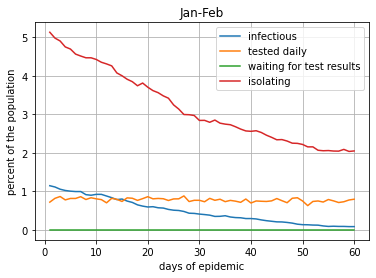

In [8]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.3 others randomly per day (see COMIX)
  3. Vaccinate the over 60s

In [9]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-24 16:09:27.390 INFO     66.0% of workplaces closed by lockdown, leaving 1659 open, of average Income Decile 4.89 (and st dev 3.14).
2021-05-24 16:09:27.405 INFO     0.0% of classrooms closed by lockdown, leaving 181 open, of average Income Decile 4.74 (and st dev 3.10).
2021-05-24 16:09:27.407 INFO     Adding 17332 permanent contact groups
2021-05-24 16:09:27.415 INFO     Adding 5948 ephemeral contact pairs
2021-05-24 16:09:27.465 INFO     Adding 11428 contacts each within one of the 8406 buildings (contact density of 0.75)


2021-05-24 16:09:29.631 INFO     Day 1, prop infected is 0.13, prop infectious is 0.0009
2021-05-24 16:09:39.479 INFO     Day 30, prop infected is 0.14, prop infectious is 0.0012
2021-05-24 16:09:39.636 INFO      Realized R0 of early infections is 0.99
2021-05-24 16:09:39.637 INFO      13.5 percent of the population was infected during the epidemic


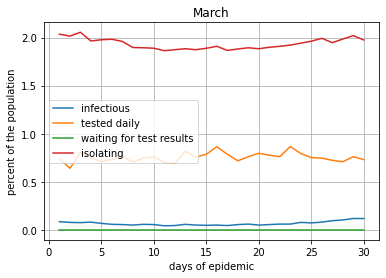

In [10]:
o_March = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [11]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

pop.seed_infections(10, indian_variant)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-24 16:09:40.002 INFO     50.0% of workplaces closed by lockdown, leaving 2470 open, of average Income Decile 4.92 (and st dev 3.14).
2021-05-24 16:09:40.019 INFO     0.0% of classrooms closed by lockdown, leaving 182 open, of average Income Decile 4.74 (and st dev 3.11).
2021-05-24 16:09:40.021 INFO     Adding 18144 permanent contact groups
2021-05-24 16:09:40.033 INFO     Adding 7931 ephemeral contact pairs
2021-05-24 16:09:40.084 INFO     Adding 11438 contacts each within one of the 8406 buildings (contact density of 0.75)


2021-05-24 16:09:42.419 INFO     Day 1, prop infected is 0.14, prop infectious is 0.0014
2021-05-24 16:09:52.704 INFO     Day 30, prop infected is 0.14, prop infectious is 0.0006
2021-05-24 16:09:52.865 INFO      Realized R0 of early infections is 0.87
2021-05-24 16:09:52.866 INFO      13.8 percent of the population was infected during the epidemic


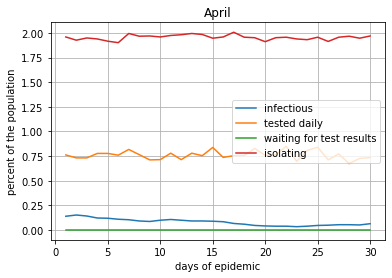

In [12]:
o_April = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [13]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-24 16:09:53.288 INFO     33.0% of workplaces closed by lockdown, leaving 3104 open, of average Income Decile 4.93 (and st dev 3.14).
2021-05-24 16:09:53.303 INFO     0.0% of classrooms closed by lockdown, leaving 186 open, of average Income Decile 4.78 (and st dev 3.11).
2021-05-24 16:09:53.305 INFO     Adding 18782 permanent contact groups
2021-05-24 16:09:53.355 INFO     Adding 9914 ephemeral contact pairs
2021-05-24 16:09:53.657 INFO     Adding 11409 contacts each within one of the 8406 buildings (contact density of 0.75)


### Surge Vaccinations all people over 16?

In [14]:
# for p in pop.people:
#     if p.age > 16:
#         p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-24 16:09:55.617 INFO     Day 1, prop infected is 0.14, prop infectious is 0.0006
2021-05-24 16:10:06.044 INFO     Day 30, prop infected is 0.14, prop infectious is 0.0012
2021-05-24 16:10:06.204 INFO      Realized R0 of early infections is 1.03
2021-05-24 16:10:06.205 INFO      14.2 percent of the population was infected during the epidemic


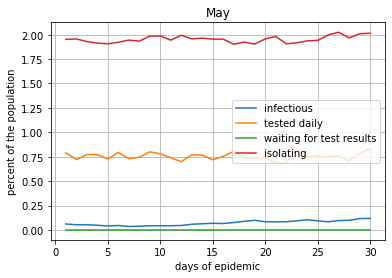

In [15]:
o_May = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")